In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Load data
filename = 'droplet_data.csv'
df = pd.read_csv(filename).dropna()
data = df.to_numpy()

# Input and output extraction
x_train = data[:, 0:3]
y_train_time = data[:, 12]
y_train_vol = data[:, 11]



x_train_scaled = (x_train - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)

In [2]:
kernel = 1.0 * Matern(nu=0.5)

gpr_time = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.1, normalize_y=True)
gpr_vol = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.1, normalize_y=True)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# To store the performance scores (MSE in this case)
mse_time = []
mse_vol = []

# Perform K-Fold Cross-Validation
for train_index, test_index in kf.split(x_train_scaled):
    # Split the data into train and test sets
    X_train, X_test = x_train_scaled[train_index], x_train_scaled[test_index]
    y_time_train, y_time_test = y_train_time[train_index], y_train_time[test_index]
    y_vol_train, y_vol_test = y_train_vol[train_index], y_train_vol[test_index]


    gpr_time.fit(X_train, y_time_train)
    gpr_vol.fit(X_train, y_vol_train)

    time_pred = gpr_time.predict(X_test)
    vol_predict = gpr_vol.predict(X_test)

    # Compute the mean squared error (MSE) for the fold
    mse_t = mean_squared_error(y_time_test, time_pred)
    mse_time.append(mse_t)

    mse_v = mean_squared_error(y_vol_test, vol_predict)
    mse_vol.append(mse_v)

    r2_t = r2_score(y_time_test, time_pred)
    r2_v = r2_score(y_vol_test, vol_predict)
    print("R² score(cross validation time):", r2_t)
    print("R² score(cross validation volume):", r2_v)

avg_mse_t = np.mean(mse_time)
avg_mse_v = np.mean(mse_vol)
print(f"Average Mean Squared Error from Cross-Validation on time model: {avg_mse_t}")
print(f"Average Mean Squared Error from Cross-Validation on volume model: {avg_mse_v}")

R² score(cross validation time): 0.9908679995421799
R² score(cross validation volume): 0.9955760643083572
R² score(cross validation time): 0.9900596571010841
R² score(cross validation volume): 0.9904711534193303
R² score(cross validation time): 0.9710582045279432
R² score(cross validation volume): 0.9942661358516212
R² score(cross validation time): 0.9894156217379911
R² score(cross validation volume): 0.995857549235707
R² score(cross validation time): 0.9584747881946194
R² score(cross validation volume): 0.9961050276240698
Average Mean Squared Error from Cross-Validation on time model: 1.1259362752789602e-07
Average Mean Squared Error from Cross-Validation on volume model: 4.1386224761127213e-19


In [3]:

gpr_time = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.1, normalize_y=True)
gpr_vol = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0.1, normalize_y=True)

gpr_time.fit(x_train, y_train_time)
gpr_vol.fit(x_train, y_train_vol)

y_hat_time, y_sigma_time = gpr_time.predict(x_train, return_std=True)
y_hat_vol, y_sigma_vol = gpr_vol.predict(x_train, return_std=True)


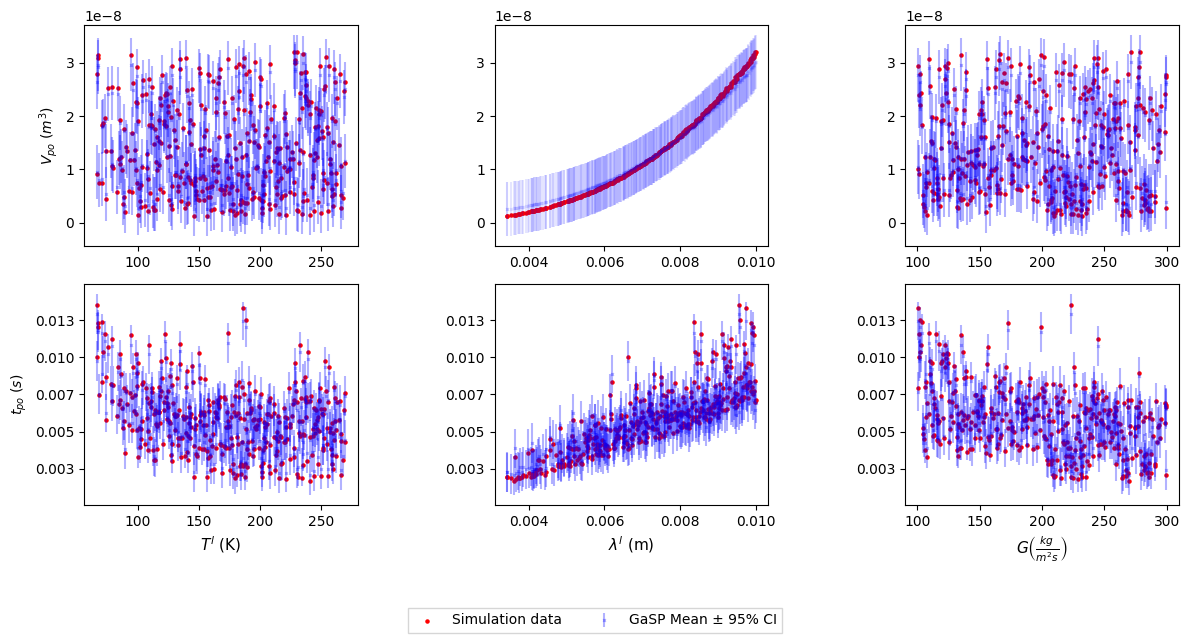

In [4]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

# Volume vs inputs
axs[0, 0].scatter(x_train[:, 0], y_train_vol, c='red', s=5, label='Simulation data')
axs[0, 0].errorbar(x_train[:, 0], y_hat_vol, yerr=1.96 * y_sigma_vol, fmt='x', color='blue', markersize=2, label='GaSP Mean ± 95% CI', alpha = .3)
axs[0, 0].set_ylabel(r'$V_{po} \ (m^3)$')

axs[0, 1].scatter(x_train[:, 1], y_train_vol, c='red', s=5)
axs[0, 1].errorbar(x_train[:, 1], y_hat_vol, yerr=1.96 * y_sigma_vol, fmt='x', color='blue', markersize=2, alpha = .1)

axs[0, 2].scatter(10 * x_train[:, 2], y_train_vol, c='red', s=5)
axs[0, 2].errorbar(10 * x_train[:, 2], y_hat_vol, yerr=1.96 * y_sigma_vol, fmt='x', color='blue', markersize=2, alpha = .3)

# Time vs inputs
axs[1, 0].scatter(x_train[:, 0], y_train_time, c='red', s=5)
axs[1, 0].errorbar(x_train[:, 0], y_hat_time, yerr=1.96 * y_sigma_time, fmt='x', color='blue', markersize=2, alpha = .3)
axs[1, 0].set_xlabel(r'$T^l$ (K)', fontsize=11)
axs[1, 0].set_ylabel(r'$t_{po} \ (s)$')
axs[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

axs[1, 1].scatter(x_train[:, 1], y_train_time, c='red', s=5)
axs[1, 1].errorbar(x_train[:, 1], y_hat_time, yerr=1.96 * y_sigma_time, fmt='x', color='blue', markersize=2, alpha = .3)
axs[1, 1].set_xlabel(r'$\lambda^l$ (m)', fontsize=11)
axs[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

axs[1, 2].scatter(10 * x_train[:, 2], y_train_time, c='red', s=5)
axs[1, 2].errorbar(10 * x_train[:, 2], y_hat_time, yerr=1.96 * y_sigma_time, fmt='x', color='blue', markersize=2, alpha = .3)
axs[1, 2].set_xlabel(r'$G \left(\frac{kg}{m^2s}\right)$', fontsize=11)
axs[1, 2].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))

# Layout and legend
fig.tight_layout()
fig.subplots_adjust(bottom=0.15, wspace=0.5)
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=False, shadow=False, ncol=2)

# Save figure
plt.savefig('GPtrain_accuracy_gravity_2D.png', bbox_inches='tight', dpi=800)
plt.show()

In [ ]:
def pdf_given_mass_num_droplets(mass, num_droplets, tolerance):
    accepted_masses = []
    for i in range(100):
        sample = kde.resample(num_droplets)[0] # extract scalar from 2D array
        if np.isclose(np.sum(sample), mass, atol=tolerance):
            accepted_masses.extend(sample)
        
    accepted_masses = np.array(accepted_masses)

    accepted_masses = accepted_masses/sum(accepted_masses)

    # Plot the histogram of your samples
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.histplot(accepted_masses, bins=100, stat='density', kde=True, color='skyblue', edgecolor='black')

    plt.title("PDF of mass_distribution given total mass")
    plt.xlabel("Sampled volume")
    plt.ylabel("Probability Density")
    plt.tight_layout()
    plt.show()
    print(sum(accepted_masses)/len(accepted_masses))
    return accepted_masses
        

In [ ]:
def pdf_given_mass_num_droplets(mass, num_droplets, tolerance):
    accepted_masses = []
    for i in range(100):
        sample = kde.resample(num_droplets)[0] # extract scalar from 2D array
        if np.isclose(np.sum(sample), mass, atol=tolerance):
            accepted_masses.extend(sample)
        
    accepted_masses = np.array(accepted_masses)

    accepted_masses = accepted_masses/sum(accepted_masses)

    # Plot the histogram of your samples
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.histplot(accepted_masses, bins=100, stat='density', kde=True, color='skyblue', edgecolor='black')

    plt.title("PDF of mass_distribution given total mass")
    plt.xlabel("Sampled volume")
    plt.ylabel("Probability Density")
    plt.tight_layout()
    plt.show()
    print(sum(accepted_masses)/len(accepted_masses))
    return accepted_masses
        

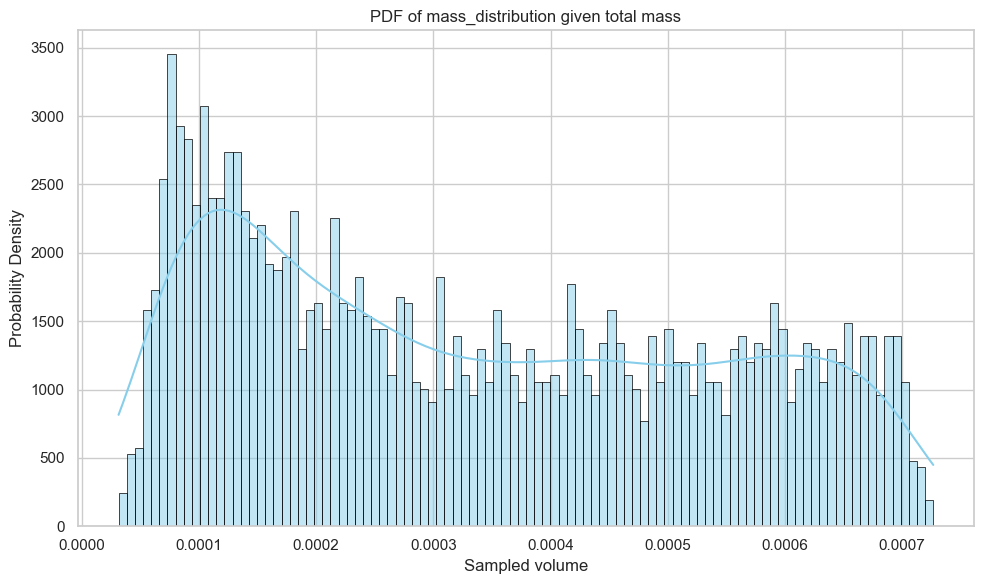

0.0003333333333333341


array([1.04407033e-04, 8.68197616e-05, 1.01154755e-04, ...,
       7.46271520e-05, 1.48034254e-04, 1.87508401e-04])

In [ ]:
pdf_given_mass_num_droplets(0.0015, 1000, 0.00046)